<a href="https://colab.research.google.com/github/RahulSundar/CS6910-DeepLearningFundamentals/blob/main/Assignment3/Assignment3_Seq2Seq_NeuralMachineTranslation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Downloading the **Dakshina** dataset:


In [2]:
!wget https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar

!tar -xf dakshina_dataset_v1.0.tar

--2023-04-02 11:07:40--  https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 142.251.31.128, 142.251.18.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2008340480 (1.9G) [application/x-tar]
Saving to: ‘dakshina_dataset_v1.0.tar’

dakshina_dataset_v1 100%[===================>]   1.87G  40.5MB/s    in 49s     

2023-04-02 11:08:29 (38.8 MB/s) - ‘dakshina_dataset_v1.0.tar’ saved [2008340480/2008340480]



## 2. Processing of the **Dakshina** dataset

### 2.1 Data Processing Class:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import pathlib


class DataProcessing():

    def __init__(self, DATAPATH, source_lang = 'en', target_lang = "bn"):
    
        self.source_lang = source_lang
        self.target_lang = target_lang
    
        self.trainpath = os.path.join(DATAPATH, target_lang, "lexicons", target_lang+".translit.sampled.train.tsv")
        self.valpath = os.path.join(DATAPATH, target_lang, "lexicons", target_lang+".translit.sampled.dev.tsv")
        self.testpath = os.path.join(DATAPATH, target_lang, "lexicons", target_lang+".translit.sampled.test.tsv")
        self.train = pd.read_csv(
            self.trainpath,
            sep="\t",
            names=["tgt", "src", "count"],
        )
        self.val = pd.read_csv(
            self.valpath,
            sep="\t",
            names=["tgt", "src", "count"],
        )
        self.test = pd.read_csv(
            self.testpath,
            sep="\t",
            names=["tgt", "src", "count"],
        )

        # create train data
        self.train_data = self.preprocess(self.train["src"].to_list(), self.train["tgt"].to_list())
        #print(self.train_data.shape)
        #print(self.train_data[0])
        (
            self.train_encoder_input,
            self.train_decoder_input,
            self.train_decoder_target,
            self.source_vocab,
            self.target_vocab,
        ) = self.train_data
        self.source_char2int, self.source_int2char = self.source_vocab
        self.target_char2int, self.target_int2char = self.target_vocab

        # create val data (only encode function suffices as the dictionary lookup should be kep the same.
        self.val_data = self.encode(
            self.val["src"].to_list(),
            self.val["tgt"].to_list(),
            list(self.source_char2int.keys()),
            list(self.target_char2int.keys()),
            source_char2int=self.source_char2int,
            target_char2int=self.target_char2int,
        )
        self.val_encoder_input, self.val_decoder_input, self.val_decoder_target = self.val_data
        self.source_char2int, self.source_int2char = self.source_vocab
        self.target_char2int, self.target_int2char = self.target_vocab

        # create test data
        self.test_data = self.encode(
            self.test["src"].to_list(),
            self.test["tgt"].to_list(),
            list(self.source_char2int.keys()),
            list(self.target_char2int.keys()),
            source_char2int=self.source_char2int,
            target_char2int=self.target_char2int,
        )
        self.test_encoder_input, self.test_decoder_input, self.test_decoder_target = self.test_data
        self.source_char2int, self.source_int2char = self.source_vocab
        self.target_char2int, self.target_int2char = self.target_vocab
        print(self.val_encoder_input.shape)
        print(self.val_decoder_input.shape)
        print(self.val_decoder_target.shape)
    


    def dictionary_lookup(self, vocab):
        char2int = dict([(char, i) for i, char in enumerate(vocab)])
        int2char = dict((i, char) for char, i in char2int.items())
        return char2int, int2char


    def encode(self, source, target, source_chars, target_chars, source_char2int=None, target_char2int=None):
        print(f"encode ==> source:{source[500:510]}")
        print(f"encode ==> target:{target[500:510]}")
        num_encoder_tokens = len(source_chars)
        num_decoder_tokens = len(target_chars)
        max_source_length = max([len(txt) for txt in source])
        max_target_length = max([len(txt) for txt in target])

        source_vocab, target_vocab = None, None
        if source_char2int == None and target_char2int == None:
            print("Generating the dictionary lookups for character to integer mapping and back")
            source_char2int, source_int2char = self.dictionary_lookup(source_chars)
            target_char2int, target_int2char = self.dictionary_lookup(target_chars)

            source_vocab = (source_char2int, source_int2char)
            target_vocab = (target_char2int, target_int2char)

        encoder_input_data = np.zeros(
            (len(source), max_source_length, num_encoder_tokens), dtype="float32"
        )
        decoder_input_data = np.zeros(
            (len(source), max_target_length, num_decoder_tokens), dtype="float32"
        )
        decoder_target_data = np.zeros(
            (len(source), max_target_length, num_decoder_tokens), dtype="float32"
        )

        for i, (input_text, target_text) in enumerate(zip(source, target)):
            for t, char in enumerate(input_text):
                encoder_input_data[i, t, source_char2int[char]] = 1.0
            encoder_input_data[i, t + 1 :, source_char2int[" "]] = 1.0
            for t, char in enumerate(target_text):
                # decoder_target_data is ahead of decoder_input_data by one timestep
                decoder_input_data[i, t, target_char2int[char]] = 1.0
                if t > 0:
                    # decoder_target_data will be ahead by one timestep
                    # and will not include the start character.
                    decoder_target_data[i, t - 1, target_char2int[char]] = 1.0
            decoder_input_data[i, t + 1 :, target_char2int[" "]] = 1.0
            decoder_target_data[i, t:, target_char2int[" "]] = 1.0
        

        print(f"encode ends==> encoder_input_data:{source[500]}")
        print(f"encode ends==> encoder_input_data:{target[500]}")
        print(f"encode ends==> encoder_input_data:{encoder_input_data[500]}")
        print(f"encode ends==> decoder_input_data:{decoder_input_data[500]}")
        print(f"encode ends==> decoder_target_data:{decoder_target_data[500]}")
        print(f"encode ends==> source_vocab:{source_vocab}")
        print(f"encode ends==> target_vocab:{target_vocab}")
        if source_vocab != None and target_vocab != None:
            return (
                encoder_input_data,
                decoder_input_data,
                decoder_target_data,
                source_vocab,
                target_vocab,
            )
        else:
            return encoder_input_data, decoder_input_data, decoder_target_data


    def preprocess(self, source , target):
        #print(f"preprocess ==> source:{source.shape}, source:{target.shape},")
        print(f"preprocess ==> source:{source[500:510]}, source:{target[500:510]}")
        source_chars = set()
        target_chars = set()

        source = [str(x) for x in source]
        target = [str(x) for x in target]

        source_words = []
        target_words = []
        for src, tgt in zip(source, target):
            tgt = "\t" + tgt + "\n"
            source_words.append(src)
            target_words.append(tgt)
            for char in src:
                if char not in source_chars:
                    source_chars.add(char)
            for char in tgt:
                if char not in target_chars:
                    target_chars.add(char)

        source_chars = sorted(list(source_chars))
        target_chars = sorted(list(target_chars))

        #The space needs to be appended so that the encode function doesn't throw errors
        source_chars.append(" ")
        target_chars.append(" ")

        num_encoder_tokens = len(source_chars)
        num_decoder_tokens = len(target_chars)
        max_source_length = max([len(txt) for txt in source_words])
        max_target_length = max([len(txt) for txt in target_words])

        print("Number of samples:", len(source))
        print("Source Vocab length:", num_encoder_tokens)
        print("Target Vocab length:", num_decoder_tokens)
        print("Max sequence length for inputs:", max_source_length)
        print("Max sequence length for outputs:", max_target_length)

        #print(f"preprocess ends ==> source:{source_words.shape}, source:{target_words.shape},")
        print(f"preprocess ends==> source_words:{source_words[500:510]}")
        print(f"preprocess ends==> target_words:{target_words[500:510]}")
        print(f"preprocess ends==> source_chars:{source_chars[500:510]}")
        print(f"preprocess ends==> target_chars:{target_chars[500:510]}")
        return self.encode(source_words, target_words, source_chars, target_chars)



### 2.2 Processing the database

Default input language is English and output language is Telugu

In [4]:
import numpy as np
import pandas as pd
import os

DATAPATH = "./dakshina_dataset_v1.0"
# DATAPATH = '../downloads/Dakshina Dataset'

#By default source language is english and target lang is telugu
dataBase = DataProcessing(DATAPATH, source_lang='en', target_lang='hi') 



preprocess ==> source:['atoot', 'atut', 'attend', 'attendance', 'attendants', 'attack', 'atharahvin', 'attharahvi', 'attharahvin', 'atarah'], source:['अटूट', 'अटूट', 'अटेंड', 'अटेंडेंट्स', 'अटेंडेंट्स', 'अटैक', 'अट्ठारहवीं', 'अट्ठारहवीं', 'अट्ठारहवीं', 'अठारह']
Number of samples: 44204
Source Vocab length: 27
Target Vocab length: 66
Max sequence length for inputs: 20
Max sequence length for outputs: 21
preprocess ends==> source_words:['atoot', 'atut', 'attend', 'attendance', 'attendants', 'attack', 'atharahvin', 'attharahvi', 'attharahvin', 'atarah']
preprocess ends==> target_words:['\tअटूट\n', '\tअटूट\n', '\tअटेंड\n', '\tअटेंडेंट्स\n', '\tअटेंडेंट्स\n', '\tअटैक\n', '\tअट्ठारहवीं\n', '\tअट्ठारहवीं\n', '\tअट्ठारहवीं\n', '\tअठारह\n']
preprocess ends==> source_chars:[]
preprocess ends==> target_chars:[]
encode ==> source:['atoot', 'atut', 'attend', 'attendance', 'attendants', 'attack', 'atharahvin', 'attharahvi', 'attharahvin', 'atarah']
encode ==> target:['\tअटूट\n', '\tअटूट\n', '\tअटेंड

## 3. Recurrent neural networks based model for sequence to sequence machine translation 
### 3.1 Seq2Seq **Translation** Model class

In [5]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from keras import layers
 

#from keras import Input, Model
from keras.layers import Dense, Input, InputLayer, Flatten, Activation, LSTM, SimpleRNN, GRU, TimeDistributed
from keras.utils import plot_model
from keras.models import load_model, Sequential,  Model
from keras.callbacks import EarlyStopping



class S2STranslation():

    def __init__(self, modelConfigDict, srcChar2Int, tgtChar2Int, using_pretrained_model = False):
        print(modelConfigDict)
        #self.native_vocabulary = modelConfigDict["native_vocabulary"]
        self.numEncoders = modelConfigDict["numEncoders"]
        self.cell_type = modelConfigDict["cell_type"]
        self.latentDim = modelConfigDict["latentDim"]
        self.dropout = modelConfigDict["dropout"]
        self.numDecoders = modelConfigDict["numDecoders"]
        self.hidden = modelConfigDict["hidden"]
        self.tgtChar2Int = tgtChar2Int
        self.srcChar2Int = srcChar2Int

    def build_configurable_model(self):       
        if self.cell_type == "RNN":
            # encoder
            encoder_inputs = Input(shape=(None, len(self.srcChar2Int)))
            encoder_outputs = encoder_inputs
            for i in range(1, self.numEncoders + 1):
                encoder = SimpleRNN(
                    self.latentDim,
                    return_state=True,
                    return_sequences=True,
                    dropout=self.dropout,
                    name = 'encoder_rnn_' + str(i)
                )
                encoder_outputs, state = encoder(encoder_inputs)
            encoder_states = [state]

            # decoder
            decoder_inputs = Input(shape=(None, len(self.tgtChar2Int)))
            decoder_outputs = decoder_inputs
            for i in range(1, self.numDecoders + 1):
                decoder = SimpleRNN(
                    self.latentDim,
                    return_sequences=True,
                    return_state=True,
                    dropout=self.dropout,
                    name = 'decoder_rnn_' + str(i)
                )
                decoder_outputs, _ = decoder(decoder_inputs, initial_state=encoder_states)

            # dense
            hidden = Dense(self.hidden, activation="relu")
            hidden_outputs = hidden(decoder_outputs)
            decoder_dense = Dense(len(self.tgtChar2Int), activation="softmax")
            decoder_outputs = decoder_dense(hidden_outputs)
            model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
            
            return model
        
        elif self.cell_type == "LSTM":
            # encoder
            encoder_inputs = Input(shape=(None, len(self.srcChar2Int)))
            encoder_outputs = encoder_inputs
            for i in range(1, self.numEncoders + 1):
                encoder = LSTM(
                    self.latentDim,
                    return_state=True,
                    return_sequences=True,
                    dropout=self.dropout,
                    name = 'encoder_lstm_' + str(i)
                )
                encoder_outputs, state_h, state_c = encoder(encoder_outputs)
            encoder_states = [state_h, state_c]
            # decoder
            decoder_inputs = Input(shape=(None, len(self.tgtChar2Int)))
            decoder_outputs = decoder_inputs
            for i in range(1, self.numDecoders + 1):
                decoder = LSTM(
                    self.latentDim,
                    return_state=True,
                    return_sequences=True,
                    dropout=self.dropout,
                    name = 'decoder_lstm_' + str(i)
                )
                decoder_outputs, _, _ = decoder(
                    decoder_outputs, initial_state=encoder_states
                )

            # dense
            hidden = Dense(self.hidden, activation="relu")
            hidden_outputs = hidden(decoder_outputs)
            decoder_dense = Dense(len(self.tgtChar2Int), activation="softmax")
            decoder_outputs = decoder_dense(hidden_outputs)
            model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
            return model
        
        elif self.cell_type == "GRU":
            # encoder
            encoder_inputs = Input(shape=(None, len(self.srcChar2Int)))
            encoder_outputs = encoder_inputs
            for i in range(1, self.numEncoders + 1):
                encoder = GRU(
                    self.latentDim,
                    return_state=True,
                    return_sequences=True,
                    dropout=self.dropout,
                    name = 'encoder_gru_' + str(i)
                )
                encoder_outputs, state = encoder(encoder_inputs)
            encoder_states = [state]
            # decoder
            decoder_inputs = Input(shape=(None, len(self.tgtChar2Int)))
            decoder_outputs = decoder_inputs
            for i in range(1, self.numDecoders + 1):
                decoder = GRU(
                    self.latentDim,
                    return_sequences=True,
                    return_state=True,
                    dropout=self.dropout,
                    name = 'decoder_gru_' + str(i)
                )
                decoder_outputs, _ = decoder(decoder_inputs, initial_state=encoder_states)

            # dense
            hidden = Dense(self.hidden, activation="relu")
            hidden_outputs = hidden(decoder_outputs)
            decoder_dense = Dense(len(self.tgtChar2Int), activation="softmax")
            decoder_outputs = decoder_dense(hidden_outputs)
            model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
            return model

### 3.2 Model Training


In [6]:
import numpy as np
import pandas as pd
import os

from keras import Input, Model
from keras.layers import RNN, LSTM, GRU, Dense
from keras.utils import plot_model
from keras.models import load_model
from keras.callbacks import EarlyStopping




import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
#Invalid device or cannot modify virtual devices once initialized.
    pass


def train(config):


    modelInit = S2STranslation(config,srcChar2Int=dataBase.source_char2int, tgtChar2Int=dataBase.target_char2int)
    
    model= modelInit.build_configurable_model()
    
    model.summary()

    model.compile(
        optimizer=config['optimiser'],
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    earlystopping = EarlyStopping(
        monitor="val_accuracy", min_delta=0.0001, patience=config['optimiser_patience'], verbose=2, mode="auto"
    )

    train_hist = model.fit(
        [dataBase.train_encoder_input, dataBase.train_decoder_input],
        dataBase.train_decoder_target,
        batch_size= config['batch_size'],
        epochs=config['epochs'],
        validation_data=([dataBase.val_encoder_input, dataBase.val_decoder_input], dataBase.val_decoder_target),
        callbacks=[earlystopping],
    )

    plot_history(train_hist)
    
    return model,train_hist






In [7]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot the training history
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

{'cell_type': 'LSTM', 'latentDim': 256, 'hidden': 64, 'optimiser': <keras.optimizers.legacy.adam.Adam object at 0x7f0084145bb0>, 'numEncoders': 1, 'numDecoders': 1, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32, 'optimiser_patience': 5}
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 27)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 66)]   0           []                               
                                                                                                  
 encoder_lstm_1 (LSTM)          [(None, None, 256),  290816      ['input_1[0][0]']                
                                 (None, 256),        

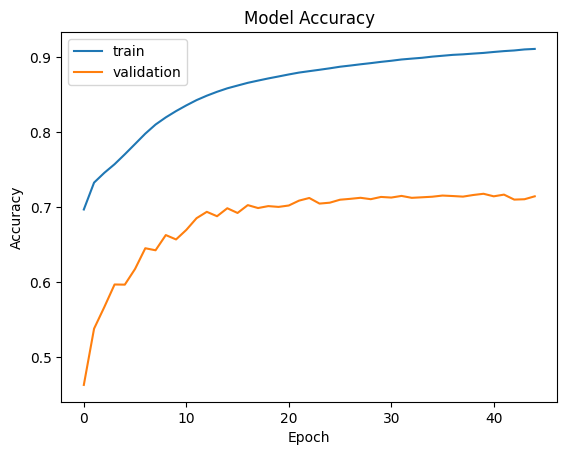

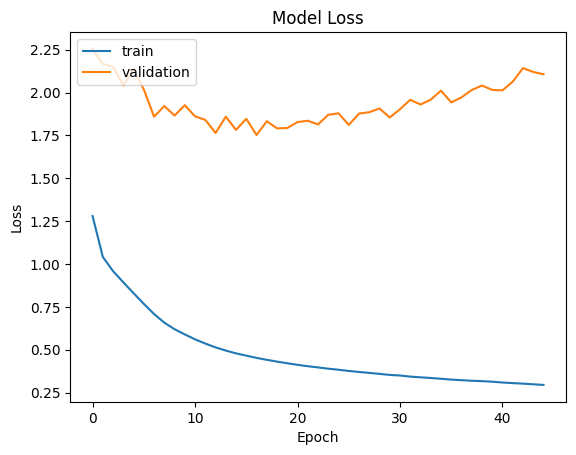

In [8]:
from keras import optimizers

config_default = {
    "cell_type": "LSTM",
    "latentDim": 256,
    "hidden": 64,
    "optimiser": optimizers.Adam(learning_rate=0.0001),
    "numEncoders": 1,
    "numDecoders": 1,
    "dropout": 0.1,
    "epochs": 100,
    "batch_size": 32,
    'optimiser_patience':5
}
model,_ = train(config_default)


In [9]:
# Evaluate the model on test data
loss, accuracy = model.evaluate([dataBase.test_encoder_input, dataBase.test_decoder_input],
        dataBase.test_decoder_target,)

# Print the test accuracy
print('Test accuracy:', accuracy)


141/141 [==============================] - 2s 6ms/step - loss: 2.0381 - accuracy: 0.7154
Test accuracy: 0.7154449820518494


In [10]:
config = config_default
if config['cell_type'] == "LSTM":
    encoder_inputs = model.input[0]
    
    if config['numEncoders'] == 1:
        encoder_outputs, state_h_enc, state_c_enc = model.get_layer(name = "encoder_lstm_1").output 
    else:           
        encoder_outputs, state_h_enc, state_c_enc = model.get_layer(name = "encoder_lstm_"+ str(config['numEncoders'])).output

    encoder_states = [state_h_enc, state_c_enc]
    encoder_model = Model(encoder_inputs, encoder_states)

    decoder_inputs = model.input[1]
    decoder_state_input_h = Input(shape=(config['latentDim'],), name="input_3")
    decoder_state_input_c = Input(shape=(config['latentDim'],), name="input_4")
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_lstm = model.layers[-3]
    decoder_outputs, state_h_dec, state_c_dec = decoder_lstm( decoder_inputs, initial_state=decoder_states_inputs )
    decoder_states = [state_h_dec, state_c_dec]
    decoder_dense = model.layers[-2]
    decoder_outputs = decoder_dense(decoder_outputs)
    
    decoder_dense = model.layers[-1]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model(
        [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
    )
elif config['cell_type'] == "GRU" or config['cell_type'] == "RNN":
    encoder_inputs = model.input[0]
    if config['cell_type'] == "GRU":
        if config['numEncoders'] == 1:
            encoder_outputs, state = model.get_layer(name = "gru").output
        else:
            encoder_outputs, state = model.get_layer(name = "gru_"+ str(config.numEncoders-1)).output
    else:
        if config['numEncoders'] == 1:
            encoder_outputs, state = model.get_layer(name = "simple_rnn").output
        else:
            encoder_outputs, state = model.get_layer(name = "simple_rnn_"+ str(config.numEncoders-1)).output

    encoder_states = [state]

    encoder_model = Model(encoder_inputs, encoder_states)

    decoder_inputs = model.input[1]

    decoder_state = Input(shape=(config['latentDim'],), name="input_3")
    decoder_states_inputs = [decoder_state]

    decoder_gru = model.layers[-3]
    (decoder_outputs, state,) = decoder_gru(decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state]
    decoder_dense = model.layers[-2]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_dense = model.layers[-1]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model(
        [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
    )

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq,verbose = 0)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, len(dataBase.target_char2int)))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, dataBase.target_char2int["\n"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        if config['cell_type'] == "LSTM":
            output_tokens, h, c = decoder_model.predict([target_seq] + states_value,verbose = 0)
        elif config['cell_type'] == "RNN" or config['cell_type'] == "GRU":
            states_value = states_value[0].reshape((1, 256))
            output_tokens, h = decoder_model.predict([target_seq] + [states_value],verbose = 0)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = dataBase.target_int2char[sampled_token_index]
        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > 25:
            stop_condition = True
            break

        decoded_sentence += sampled_char


        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, len(dataBase.target_char2int)))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        if config['cell_type'] == "LSTM":
            states_value = [h, c]
        elif config['cell_type'] == "RNN" or config['cell_type'] == "GRU":
            states_value = [h]
    return decoded_sentence



In [13]:
acc = 0
sourcelang = []
predictions = []
original = []

for i, row in dataBase.test.sample(20).iterrows():
    input_seq = dataBase.test_encoder_input[i : i + 1]
    decoded_sentence = decode_sequence(input_seq)
    og_tokens = [dataBase.target_char2int[x] for x in row["tgt"]]
    predicted_tokens = [dataBase.target_char2int[x] for x in decoded_sentence.rstrip("\n")]
    # if decoded_sentence == row['tgt']:
    #   acc += 1
    sourcelang.append(row['src'])
    original.append(row['tgt'])
    predictions.append(decoded_sentence)

    if og_tokens == predicted_tokens:
        acc += 1
    
    if i % 1000 == 10000 :
        print(f"Finished {i} examples")
        print(f"Source: {row['src']}")
        print(f"Original: {row['tgt']}")
        print(f"Predicted: {decoded_sentence}")
        print(f"Accuracy: {acc / (i+1)}")
        #print(og_tokens)
        #print(predicted_tokens)
        

print(f'Test Accuracy: {acc}')

print(acc / len(dataBase.test))

print(sourcelang)
print(original )
print(predictions)

Test Accuracy: 3
0.0006663705019991116
['ambani', 'shavkon', 'tired', 'official', 'gomukh', 'mysore', 'avaigyanik', 'teekon', 'dikhayin', 'bheed', 'nahargadh', 'jayalalithaa', 'haldi', 'parva', 'taajaa', 'jeevan', 'uthen', 'bhraantiyan', 'bhaunhon', 'jenny']
['अंबानी', 'शावकों', 'टायर्ड', 'ऑफिशियल', 'गौमुख', 'मैसोर', 'अवैज्ञानिक', 'टीकों', 'दिखाईं', 'भीड़', 'नाहरगढ', 'जयललिता', 'हल्दी', 'परवा', 'ताजा', 'जीवन', 'उठें', 'भ्रांतियां', 'भौंहों', 'जेनी']
['अंबानी', 'श्वासों', 'टिरेड', 'ऑफिफिलिस', 'गोमकुम', 'मियोर्स', 'वाज्ञानिक्ञ', 'इंटेकों', 'दिखाइकी', 'भीद', 'नाराग्रध', 'ज्यलिलालिका', 'हाल्डी', 'प्रवा', 'ताजा', 'जीवन', 'उठाएं', 'भ्राणातियां', 'भुनाहुं', 'ज्नेनिय']


In [14]:
import pandas as pd

df = pd.DataFrame(columns=['sourcelang','original','predictions'])
df['sourcelang']=sourcelang
df['original']=original
df['predictions']=predictions
print(df.to_markdown())

|    | sourcelang   | original   | predictions   |
|---:|:-------------|:-----------|:--------------|
|  0 | ambani       | अंबानी      | अंबानी         |
|  1 | shavkon      | शावकों      | श्वासों         |
|  2 | tired        | टायर्ड      | टिरेड          |
|  3 | official     | ऑफिशियल    | ऑफिफिलिस      |
|  4 | gomukh       | गौमुख       | गोमकुम         |
|  5 | mysore       | मैसोर       | मियोर्स        |
|  6 | avaigyanik   | अवैज्ञानिक   | वाज्ञानिक्ञ     |
|  7 | teekon       | टीकों       | इंटेकों          |
|  8 | dikhayin     | दिखाईं      | दिखाइकी       |
|  9 | bheed        | भीड़        | भीद           |
| 10 | nahargadh    | नाहरगढ     | नाराग्रध       |
| 11 | jayalalithaa | जयललिता    | ज्यलिलालिका    |
| 12 | haldi        | हल्दी       | हाल्डी         |
| 13 | parva        | परवा       | प्रवा          |
| 14 | taajaa       | ताजा       | ताजा          |
| 15 | jeevan       | जीवन       | जीवन          |
| 16 | uthen        | उठें         | उठाएं          |
| 

**b)** Now train your model using the standard train, test, and val data provided in the dataset.Try below mentioned hyperparameters and draw the correlation table along with the plot (loss/accuracy VS. hyperparameter) for both RNN and LSTM. [20]

(i) Input embedding size: 16, 64

(ii) number of encoder layers: 1,3

(iii) number of decoder layers: 1,3

(iv) hidden layer size: 16,64

{'cell_type': 'RNN', 'latentDim': 16, 'hidden': 16, 'optimiser': <keras.optimizers.legacy.adam.Adam object at 0x7efec23a4ee0>, 'numEncoders': 1, 'numDecoders': 1, 'dropout': 0.1, 'epochs': 50, 'batch_size': 32, 'optimiser_patience': 5}
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, None, 27)]   0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, None, 66)]   0           []                               
                                                                                                  
 encoder_rnn_1 (SimpleRNN)      [(None, None, 16),   704         ['input_11[0][0]']               
                                 (None, 16)]          

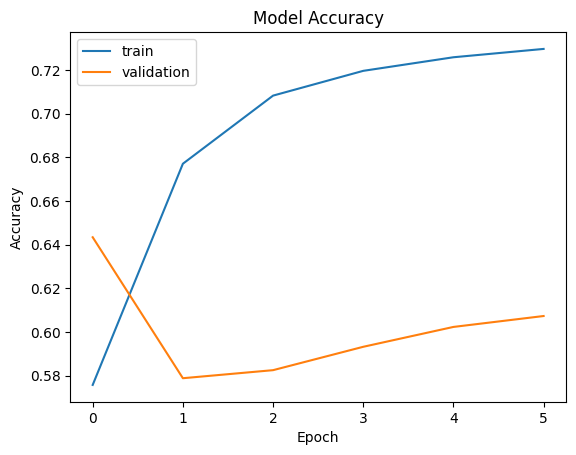

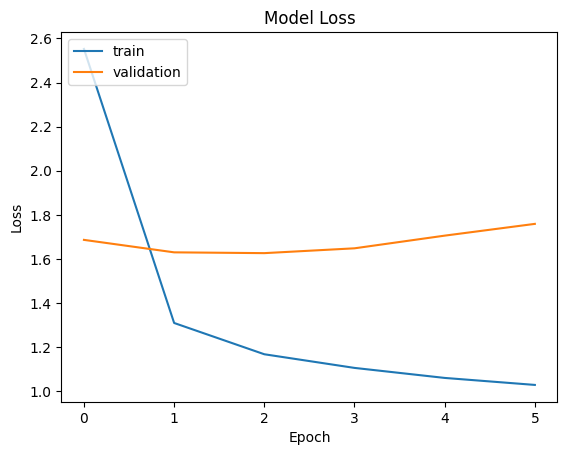

141/141 [==============================] - 2s 10ms/step - loss: 1.7016 - accuracy: 0.6321
{'cell_type': 'RNN', 'latentDim': 16, 'hidden': 16, 'optimiser': <keras.optimizers.legacy.adam.Adam object at 0x7efec23a4e50>, 'numEncoders': 1, 'numDecoders': 3, 'dropout': 0.1, 'epochs': 50, 'batch_size': 32, 'optimiser_patience': 5}
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, None, 27)]   0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, None, 66)]   0           []                               
                                                                                                  
 encoder_rnn_1 (SimpleRNN)      [(None, None, 16),   704       

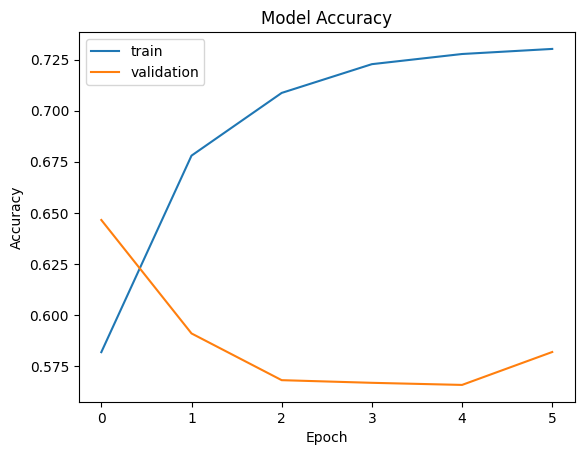

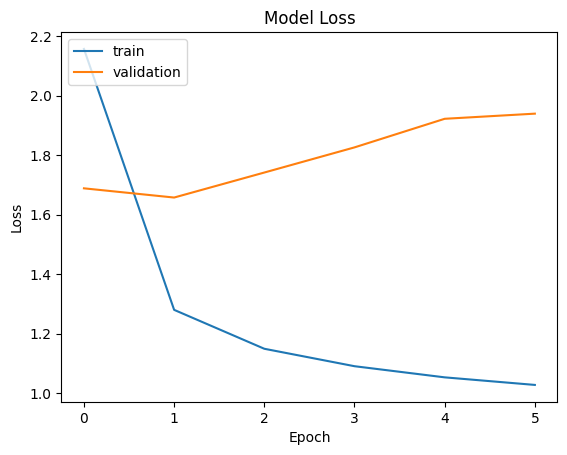

141/141 [==============================] - 2s 9ms/step - loss: 2.0232 - accuracy: 0.5808
{'cell_type': 'RNN', 'latentDim': 16, 'hidden': 16, 'optimiser': <keras.optimizers.legacy.adam.Adam object at 0x7eff22b84820>, 'numEncoders': 3, 'numDecoders': 1, 'dropout': 0.1, 'epochs': 50, 'batch_size': 32, 'optimiser_patience': 5}
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, None, 27)]   0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, None, 66)]   0           []                               
                                                                                                  
 encoder_rnn_3 (SimpleRNN)      [(None, None, 16),   704        

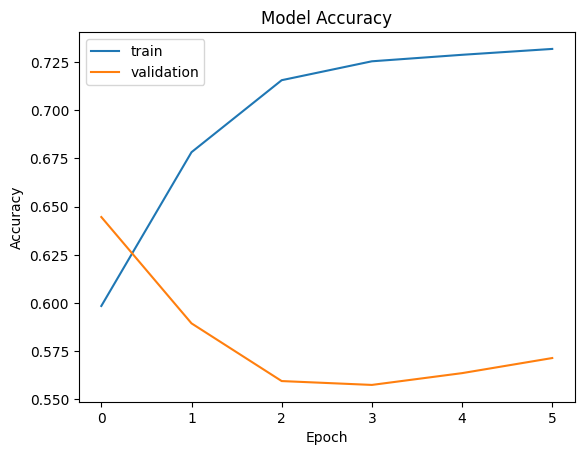

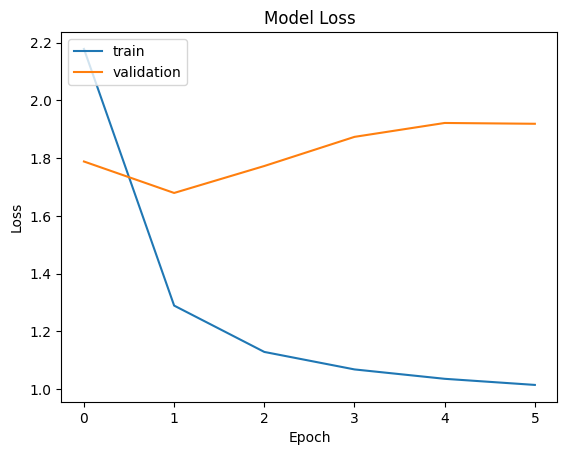

141/141 [==============================] - 1s 8ms/step - loss: 2.1378 - accuracy: 0.5617
{'cell_type': 'RNN', 'latentDim': 16, 'hidden': 16, 'optimiser': <keras.optimizers.legacy.adam.Adam object at 0x7eff0e3cd430>, 'numEncoders': 3, 'numDecoders': 3, 'dropout': 0.1, 'epochs': 50, 'batch_size': 32, 'optimiser_patience': 5}
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, None, 27)]   0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, None, 66)]   0           []                               
                                                                                                  
 encoder_rnn_3 (SimpleRNN)      [(None, None, 16),   704       

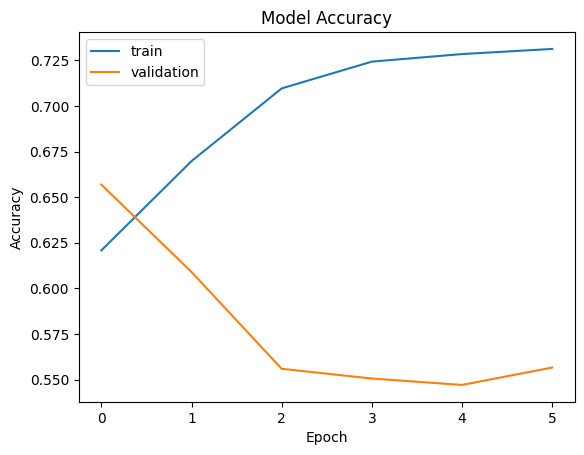

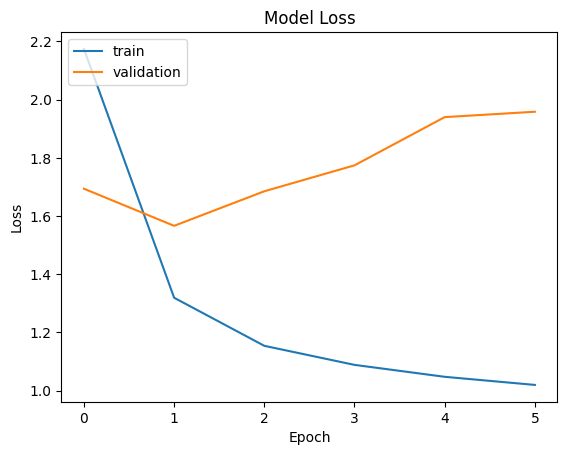

141/141 [==============================] - 1s 8ms/step - loss: 2.1293 - accuracy: 0.5639
{'cell_type': 'RNN', 'latentDim': 16, 'hidden': 64, 'optimiser': <keras.optimizers.legacy.adam.Adam object at 0x7eff0daac850>, 'numEncoders': 1, 'numDecoders': 1, 'dropout': 0.1, 'epochs': 50, 'batch_size': 32, 'optimiser_patience': 5}
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, None, 27)]   0           []                               
                                                                                                  
 input_20 (InputLayer)          [(None, None, 66)]   0           []                               
                                                                                                  
 encoder_rnn_1 (SimpleRNN)      [(None, None, 16),   704       

KeyboardInterrupt: ignored

In [44]:
hyper_params = {
    "cell_type": ["LSTM","RNN"],
    "latentDim": [ 256, 64, 16],
    "hidden": [256,64,16],
    "numEncoders": [1,3],
    "numDecoders": [1,3]
}
hyper_params_values = {
    "hp_sr_no": [],
    "cell_type": [],
    "latentDim": [],
    "hidden": [],
    "numEncoders": [],
    "numDecoders": [],
    "loss": [],
    "accuracy": [],
}
hp_sr_no = 0
best_acc = 0
best_model = -1
for cell_type in hyper_params["cell_type"]:
  for latentDim in hyper_params["latentDim"]:
    for hidden in hyper_params["hidden"]:
      for numEncoders in hyper_params["numEncoders"]:
        for numDecoders in hyper_params["numDecoders"]:
            hp_sr_no+=1
            config_default = {
                "cell_type": cell_type,
                "latentDim": latentDim,
                "hidden": hidden,
                "optimiser": optimizers.Adam(learning_rate=0.0001),
                "numEncoders": numEncoders,
                "numDecoders": numDecoders,
                "dropout": 0.1,
                "epochs": 50,
                "batch_size": 32,
                'optimiser_patience':5
            }
            model,_ = train(config_default)
            loss, accuracy = model.evaluate([dataBase.test_encoder_input, dataBase.test_decoder_input],dataBase.test_decoder_target,)

            hyper_params_values["hp_sr_no"].append(hp_sr_no)
            hyper_params_values["cell_type"].append(cell_type)
            hyper_params_values["latentDim"].append(latentDim)
            hyper_params_values["hidden"].append(hidden)
            hyper_params_values["numEncoders"].append(numEncoders)
            hyper_params_values["numDecoders"].append(numDecoders)
            hyper_params_values["loss"].append(loss)
            hyper_params_values["accuracy"].append(accuracy)


            hyper_params_df = pd.DataFrame(hyper_params_values)
            hyper_params_df.to_csv('./results/hp_tuning.csv')

            print(f'\n\n** {hyper_params_df.iloc[-1]} **\n\n')
            if accuracy > best_acc:
              best_acc = accuracy
              best_model = hp_sr_no
              model.save(f'./models/best_model.h5')

In [53]:
hyper_params_df.iloc[-1]

hp_sr_no              4
cell_type           RNN
latentDim            16
hidden               16
numEncoders           3
numDecoders           3
loss           2.129267
accuracy       0.563912
Name: 3, dtype: object